In [1]:
import jax  # Autodiff, easy batching of functions
import jax.numpy as jnp  # Like numpy but written to run fast on GPU
import numpy as np
import distrax  # Tensorflow probability for Jax
import haiku as hk  # Used for making neural nets
import tqdm  # Used for reporting training progress
import chex  # Used for checking dimensions, useful for debugging
from jax.scipy.linalg import cholesky  # Need to structure covariance appropriately for learning
from matplotlib import pyplot as plt
from functools import partial
from matplotlib import pyplot as plt
import optax  # Used for optimization using SGD, Adam etc

# plt.style.use('seaborn-v0_8-deep')

%matplotlib inline

In [2]:
ACTION_DIM = 64
batch_size = 500

In [3]:
def transform_to_cov(sq_mat):
    return jnp.dot(sq_mat.T, sq_mat)


@jax.jit
def normal_policy_log_prob(params, actions, prior_params):
  chex.assert_shape(actions, (None,ACTION_DIM))

  dist_prior = distrax.MultivariateNormalTri(
        loc=jnp.array(prior_params['loc']), scale_tri=jnp.exp(prior_params['scale'])
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=jnp.exp(params['scale'])
      )

  log_probs_prior = dist_prior.log_prob(actions)
  log_probs_model = dist_model.log_prob(actions)
  chex.assert_shape(log_probs_prior, (actions.shape[0],))
  chex.assert_shape(log_probs_model, (actions.shape[0],))

  return log_probs_model + log_probs_prior

@jax.jit
def mixture_policy_log_prob(params, actions, prior_params):
  chex.assert_shape(actions, (None,ACTION_DIM))

  dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=jnp.exp(prior_params["prior_probs"])),
        components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=jnp.exp(prior_params["scales"])),
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=jnp.exp(params['scale'])
      )

  log_probs_prior = dist_prior.log_prob(actions)
  log_probs_model = dist_model.log_prob(actions)
  chex.assert_shape(log_probs_prior, (actions.shape[0],))
  chex.assert_shape(log_probs_model, (actions.shape[0],))

  return log_probs_model + log_probs_prior

@partial(jax.jit, static_argnums=(2,))
def policy_sample(rng, params, num_samples):
  """See policy log prob."""
  eps = 1e-4
  samples = distrax.MultivariateNormalTri(
      loc=params['loc'],
      scale_tri=jnp.exp(params['scale'])
      ).sample(seed=rng, sample_shape=(num_samples,))
  chex.assert_shape(samples, (num_samples, ACTION_DIM))

  return samples

@partial(jax.jit, static_argnums=(2,))
def univariate_policy_sample(rng, params, num_samples):
  mu = jnp.array(params['loc'])
  sigma = jnp.exp(jnp.array(params['scale']))

  eps = 1e-4
  samples = distrax.Normal(loc=mu, scale=sigma).sample(seed=rng, sample_shape=(num_samples,)).reshape(-1)
  chex.assert_shape(samples, (num_samples,))

  return samples

# def loss_fn(params, actions, rewards, prior_params):
#   chex.assert_shape(actions, (batch_size,ACTION_DIM))
#   chex.assert_shape(rewards, (batch_size,))
#   # log_probs = normal_policy_log_prob(params, actions, prior_params)
#   log_probs = mixture_policy_log_prob(params, actions, prior_params)
#   chex.assert_shape(log_probs, (batch_size,))
#   rewards = jax.lax.stop_gradient(rewards)  # Don't backprop through the reward function
#   return -(rewards * log_probs).sum()

def kl_penalty(params, prior_params):
  dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=jnp.exp(prior_params["prior_probs"])),
        components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=jnp.exp(prior_params["scales"])),
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=jnp.exp(params['scale'])
      )
  
  penalty = 0
  for weight, component in zip(dist_prior.mixture_distribution.probs, dist_prior.components_distribution):
    penalty += component.kl_divergence(dist_model)*weight

  return penalty

def loss_fn(params, actions, rewards, prior_params, alpha):
  chex.assert_shape(actions, (batch_size,ACTION_DIM))
  chex.assert_shape(rewards, (batch_size,))
  # log_probs = normal_policy_log_prob(params, actions, prior_params)
  log_probs = mixture_policy_log_prob(params, actions, prior_params)
  penalty = kl_penalty(params, prior_params)
  chex.assert_shape(log_probs, (batch_size,))
  rewards = jax.lax.stop_gradient(rewards)  # Don't backprop through the reward function
  # log probs are always negative!
  # KL distance is positive, so we negative
  # negative the whole thing because we're minimizing this quantity
  return -(rewards * (log_probs)).sum() + alpha*penalty

@jax.jit
def get_rewards(a, target_params, key):
  # model = distrax.MultivariateNormalTri(loc=model_params_['loc'], scale_tri=model_params_['scale'])
  # # # sample from target distribution, then find distances
  # target_samples = target_dist.sample(seed=key, sample_shape=(a.shape[0],))
  # return -jnp.sum(jnp.subtract(a, target_samples)**2,axis=1)
  # # # subtract from target distribution mean
  return -jnp.sum(jnp.subtract(a, target_params["loc"])**2,axis=1)

@jax.jit  # This compiles the function to the GPU
def update_fn(params, actions, rewards, opt_state, prior_params, alpha, wlr=1e-4, epsilon=1e-8):
  optimizer = optax.adam(wlr)
  loss = loss_fn(params, actions, rewards, prior_params, alpha=alpha)
  grads = jax.grad(loss_fn)(params, actions, rewards, prior_params, alpha)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params['scale'] = jnp.clip(params['scale'], a_min=epsilon)  # Clip for numerical stability
  return params, opt_state, loss

In [4]:
key = jax.random.PRNGKey(0)

def setup_params():
    # manually make the prior
    prior_probs = jnp.array([0.5,0.5])

    prior_means = []
    prior_means += [jnp.concatenate([jnp.array([10., -25.]),jnp.zeros((62))])]
    prior_means += [jnp.concatenate([jnp.array([-10.,-25.]),jnp.zeros((62))])]
    prior_means = jnp.array(prior_means)

    prior_covs = []
    prior_covs += [np.eye(ACTION_DIM)*0.01]
    prior_covs[-1][:2,:2] = jnp.array([[5.0,0.0],
                                        [0.0,5.0]])
    prior_covs += [np.eye(ACTION_DIM)*0.01]
    prior_covs[-1][:2,:2] = jnp.array([[25.0,0.0],
                                 [0.0,25.0]])
    prior_scales = jnp.linalg.cholesky(jnp.array(prior_covs))
    prior_params = {
        "prior_probs" : jnp.log(prior_probs),
        "means" : prior_means,
        "scales" : jnp.log(prior_scales)
    }

    starting_mean = jnp.concatenate([jnp.array([10.,-10.]),jnp.zeros((62))])
    starting_sigma = 1.0
    starting_scale = jnp.linalg.cholesky(jnp.eye(ACTION_DIM)*starting_sigma)
    params = {
        'loc': starting_mean,
        'scale': jnp.log(starting_scale)
        }

    target_position = jnp.concatenate([jnp.array([5.0,5.0]),jnp.zeros((62))])
    target_cov = np.eye(ACTION_DIM)*0.01
    target_cov[:2,:2] = jnp.array([[15.0,  0.],
                                 [0.,  15.0]])
    target_scale = jnp.linalg.cholesky(target_cov)
    target_params = {
        'loc': target_position,
        'scale': jnp.log(target_scale)
    }
    return prior_params, params, target_params

def plot_samples(dist,num_samples,label,rng):
  # split for new samples
  key, subkey = jax.random.split(rng)
  samples = dist.sample(seed=subkey, sample_shape=(num_samples,)).T
  plt.scatter(samples[0],samples[1],label=label)

def make_target_dist(target_params):
    return  distrax.MultivariateNormalTri(
    loc=target_params['loc'],
    scale_tri=jnp.exp(target_params['scale']))

def make_prior_dist(prior_params):
   return distrax.MixtureSameFamily(
    mixture_distribution = distrax.Categorical(probs=jnp.exp(prior_params["prior_probs"])),
    components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=jnp.exp(prior_params["scales"])))

def make_starting_dist(starting_params):
    return distrax.MultivariateNormalTri(
    loc=starting_params['loc'],
    scale_tri=jnp.exp(starting_params['scale']))
   

In [5]:
prior_params, params, target_params = setup_params()

In [6]:
num_iter = 10000
learning_rate = 1e-1
opt_state = optax.adam(learning_rate).init(params)
losses = np.zeros(num_iter)
rewards = np.zeros(num_iter)
params_list = []

for t in tqdm.tqdm(range(num_iter)):
  key, subkey = jax.random.split(key)
  actions_t = policy_sample(rng=subkey, params=params, num_samples=batch_size)
  rewards_t = get_rewards(actions_t, target_params, key)
  rewards[t] = rewards_t.mean()
  params_list.append(params)
  params, opt_state, loss_t = update_fn(params, actions_t, rewards_t, opt_state, alpha=0.0, prior_params=prior_params, wlr=learning_rate)
  losses[t] = loss_t
  params_list.append(params)
means = np.array([[p["loc"][0],p["loc"][1]] for p in params_list]).T

100%|██████████| 10000/10000 [01:06<00:00, 151.01it/s]


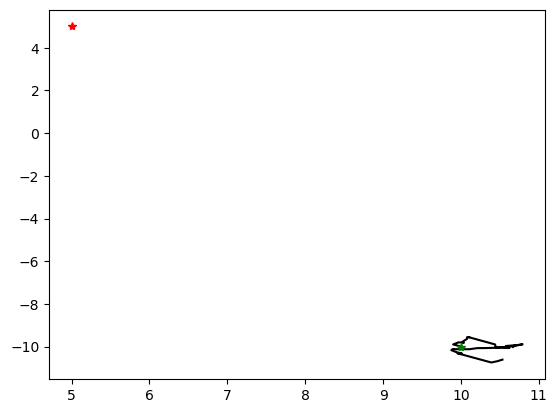

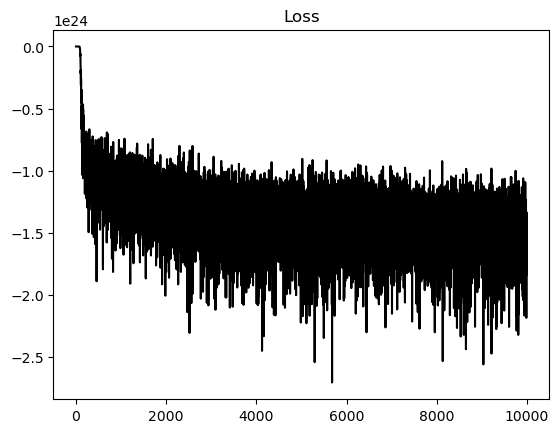

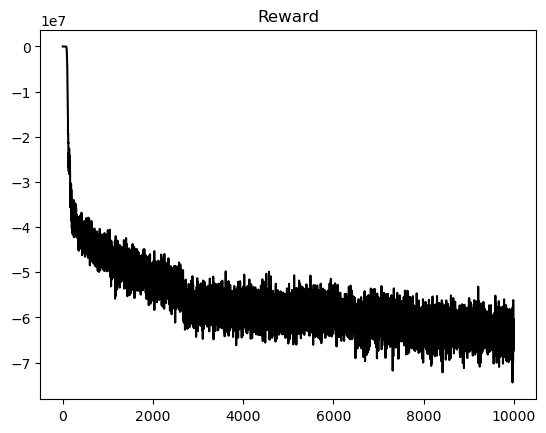

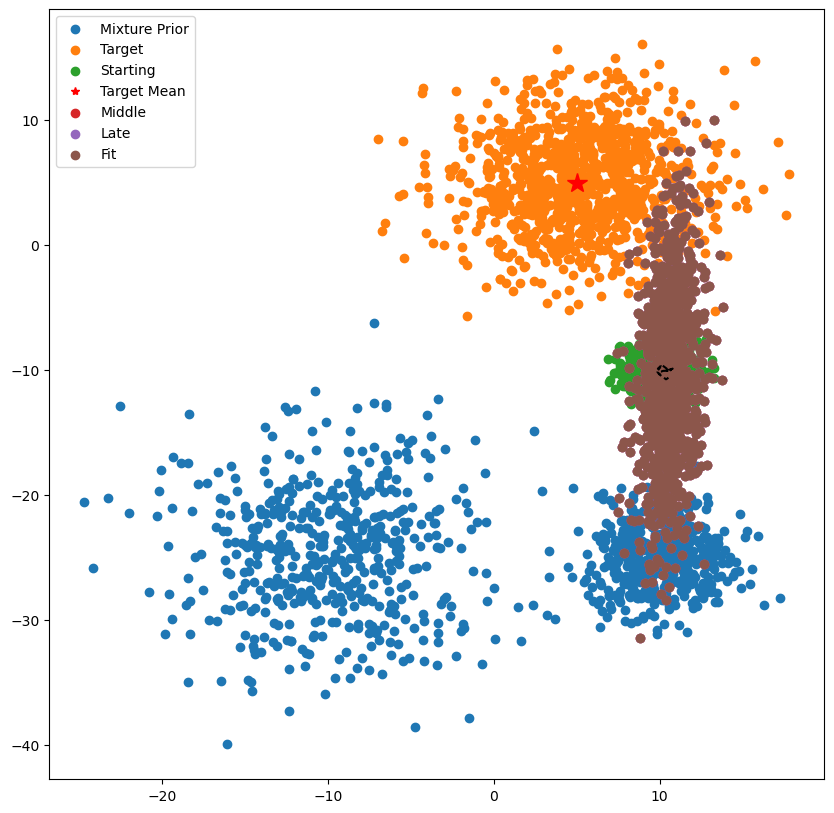

In [7]:
# def plot_2d_dist(dist):
#   xl = jnp.linspace(-20,20,100)
#   yl = jnp.linspace(-20,20,100)
#   x, y = jnp.meshgrid(xl, yl)
#   X = jnp.stack([xm.flatten(), ym.flatten()], axis=-1)
#   probs = dist.prob(X).reshape((101, 101))
#   left,right,bottom,top = xl.min(), xl.max(), yl.min(), yl.max()
#   plt.imshow(probs, extent=(left,right,bottom,top), origin="lower")
#   _ = plt.gca().set_xticks(xl[::10],labels=np.round(xl[::10]),rotation=45)
#   _ = plt.gca().set_yticks(yl[::10],labels=np.round(yl[::10]),rotation=45)

plt.figure()
plt.plot(means[0],means[1],"k-")
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*")
plt.plot(params_list[0]["loc"][0],params_list[0]["loc"][1],"g*")

plt.figure()
plt.plot(losses,"k-")
plt.title("Loss")

plt.figure()
plt.plot(rewards,"k-")
plt.title("Reward")

plt.figure(figsize=(10,10))
plt.gca().set_aspect("auto")

plot_samples(make_prior_dist(prior_params),1000,"Mixture Prior",rng=key)
plot_samples(make_target_dist(target_params),1000,"Target",rng=key)
plot_samples(make_starting_dist(params_list[0]),1000,"Starting",rng=key)
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*",label="Target Mean")

middle_dist = distrax.MultivariateNormalTri(
    loc=params_list[500]['loc'],
    scale_tri=jnp.exp(params_list[500]['scale']),
    )
plot_samples(middle_dist,1000,"Middle",key)

late_dist = distrax.MultivariateNormalTri(
    loc=params_list[-100]['loc'],
    scale_tri=jnp.exp(params_list[-100]['scale']),
    )
plot_samples(late_dist,1000,"Late",key)

fitted_dist = distrax.MultivariateNormalTri(
    loc=params['loc'],
    scale_tri=jnp.exp(params['scale']),
    )
plot_samples(fitted_dist,1000,"Fit",key)

plt.plot([p["loc"][0] for p in params_list],[p["loc"][1] for p in params_list],"k--")
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*",markersize=15)

plt.legend()